In [7]:
import pandas as pd
from pandas import DataFrame
import sqlite3
from typing import Tuple
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Count of fire incidents vs REAC score in NY by zipcode, population-weighted

Let's start by comparing the number of fire incidents that occur and average REAC scores on a zipcode-by-zipcode basis.

We'll get the New York State data for both NFIRS and REAC using SQL and pandas. Because some zipcodes are much more populous than others, we'll use Census data on zipcode population to weight the number of fires proportionately.

In [ ]:
WORKING_DIR = 'D:/Fire Project/data/'

In [9]:
pops = pd.read_csv(WORKING_DIR + 'DECENNIALSF12010.P1-Data.csv', skiprows=1)

# Split off the zipcode from the Geographic area name
pops['zipcode'] = pops['Geographic Area Name'].apply(lambda x: x.split(' ')[1])

# Get only the zip and population columns we need
pops = pops.loc[:, ['zipcode', 'Total']]

In [10]:
conn = sqlite3.Connection('fire_data.db')
cur = conn.cursor()

ny_fires = pd.read_sql("""
SELECT ZIP5 as zipcode, COUNT(*) as incidents
FROM incident_address
WHERE STATE = 'NY'
GROUP BY ZIP5
""", conn)

In [11]:
ny_fires['zipcode'] = ny_fires['zipcode'].astype(str)
pops['zipcode'] = pops['zipcode'].astype(str)

print('Size of ny_fires:', len(ny_fires))
# Adjust by population size
fires_merged = pd.merge(ny_fires, pops, on='zipcode', how='inner')
fires_merged['incidents_adj'] = fires_merged.incidents / fires_merged.Total
print('Size after merging:', len(fires_merged))

Size of ny_fires: 2292
Size after merging: 1718


In [12]:
multifamily_scores = pd.read_excel(WORKING_DIR + 'multifamily_physical_inspection_scores_0321.xlsx')
public_housing_scores = pd.read_excel(WORKING_DIR + 'public_housing_physical_inspection_scores_0321.xlsx')

In [13]:
# Filter REAC inspection data by NY state.
ny_multifamily = multifamily_scores[multifamily_scores.STATE_NAME == 'NY']
ny_public = public_housing_scores[public_housing_scores.STATE_NAME == 'NY']

In [14]:
# Get the mean inspection score in each zip code.
multifamily_avg_scores = ny_multifamily.groupby(by='ZIPCODE').mean()
public_avg_scores = ny_public.groupby(by='ZIPCODE').mean()

In [15]:
# Convert zipcode to str for matching with the NFIRS data.
# Cast to int first to avoid unnecessary decimal.
multifamily_avg_scores.index = multifamily_avg_scores.index.astype(int).astype(str)
public_avg_scores.index = public_avg_scores.index.astype(int).astype(str)

Because there are a few zipcodes that don't exist in our inspection dataset that exist in the NFIRS data, we'll do some filtering so that we're only looking at the zipcodes that are in both datasets. We'll also sort by zipcode so that each zipcode matches between the datasets.

In [16]:
# Filter down to rows matching between multifamily and NFIRS.
ny_fires_multi_subset = fires_merged[fires_merged.zipcode.isin(multifamily_avg_scores.index)]
ny_fires_multi_sorted = ny_fires_multi_subset.sort_index()
multi_subset = multifamily_avg_scores[multifamily_avg_scores.index.isin(ny_fires_multi_sorted.zipcode)]
multi_sorted = multi_subset.sort_index()

# Filter down to rows matching between public housing and NFIRS.
ny_fires_public_subset = fires_merged[fires_merged.zipcode.isin(public_avg_scores.index)]
ny_fires_public_sorted = ny_fires_public_subset.sort_index()
public_subset = public_avg_scores[public_avg_scores.index.isin(ny_fires_public_sorted.zipcode)]
public_sorted = public_subset.sort_index()

Now that our data is ready to join, we'll make a quick plot of the multifamily data and the public housing data.

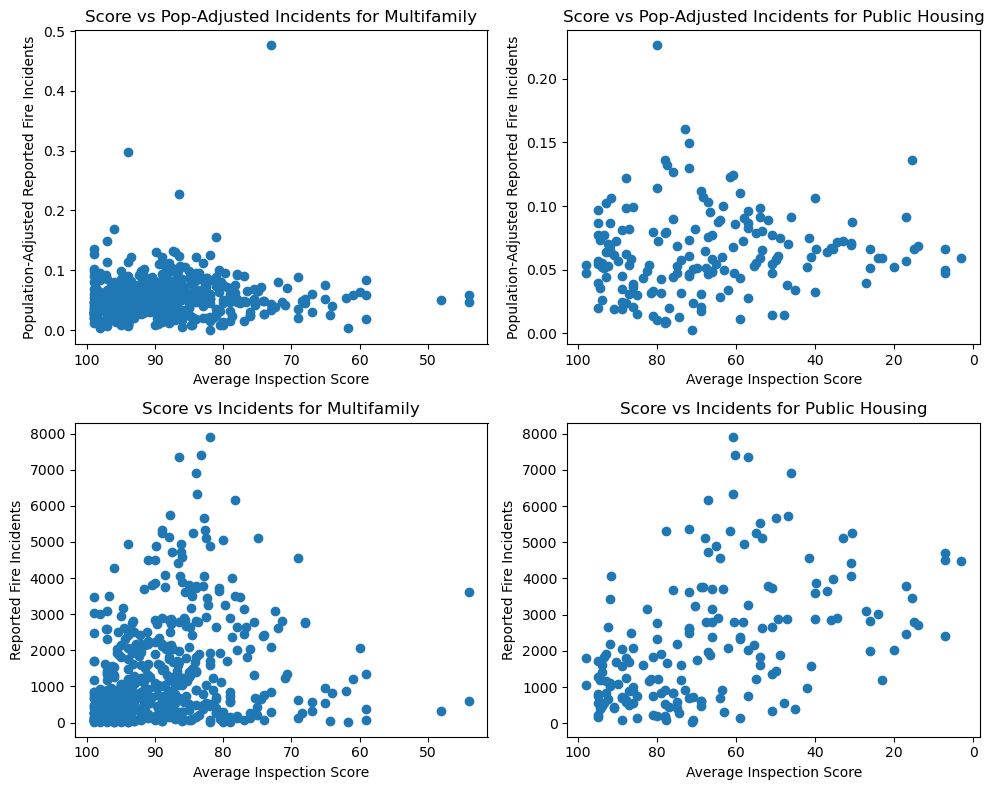

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Score vs Pop-Adjusted Incidents for Multifamily
axs[0, 0].scatter(multi_sorted.INSPECTION_SCORE, ny_fires_multi_sorted.incidents_adj)
axs[0, 0].set_xlim(axs[0, 0].get_xlim()[::-1])
axs[0, 0].set_xlabel('Average Inspection Score')
axs[0, 0].set_ylabel('Population-Adjusted Reported Fire Incidents')
axs[0, 0].set_title('Score vs Pop-Adjusted Incidents for Multifamily')

# Score vs Pop-Adjusted Incidents for Public Housing
axs[0, 1].scatter(public_sorted.INSPECTION_SCORE, ny_fires_public_sorted.incidents_adj)
axs[0, 1].set_xlim(axs[0, 1].get_xlim()[::-1])
axs[0, 1].set_xlabel('Average Inspection Score')
axs[0, 1].set_ylabel('Population-Adjusted Reported Fire Incidents')
axs[0, 1].set_title('Score vs Pop-Adjusted Incidents for Public Housing')

# Score vs Incidents for Multifamily
axs[1, 0].scatter(multi_sorted.INSPECTION_SCORE, ny_fires_multi_sorted.incidents)
axs[1, 0].set_xlim(axs[1, 0].get_xlim()[::-1])
axs[1, 0].set_xlabel('Average Inspection Score')
axs[1, 0].set_ylabel('Reported Fire Incidents')
axs[1, 0].set_title('Score vs Incidents for Multifamily')

# Score vs Incidents for Public Housing
axs[1, 1].scatter(public_sorted.INSPECTION_SCORE, ny_fires_public_sorted.incidents)
axs[1, 1].set_xlim(axs[1, 1].get_xlim()[::-1])
axs[1, 1].set_xlabel('Average Inspection Score')
axs[1, 1].set_ylabel('Reported Fire Incidents')
axs[1, 1].set_title('Score vs Incidents for Public Housing')

# Adjust spacing between subplots
fig.tight_layout()

# Show the entire plot
plt.show()


Overall, it looks like there is essentially no coorelation between the zipcodes with low average inspection scores in New York state, and the number of fire incidents per zip code. However, we can go more granular by looking at a smaller geographic footprint in a separate notebook.